In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

from cityscapes import CityScapes

# Create separate datasets for train, val, and test splits
cityscapes_path = "/arf/home/myadiyaman/projeler/hydracity/data/cityscapes"
train_dataset = CityScapes(cityscapes_path, split="train")
val_dataset = CityScapes(cityscapes_path, split="val")
#test_dataset = CityScapes(cityscapes_path, split="test")

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
#test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Example: Iterate over the train loader
for batch_idx, batch in enumerate(train_dataloader):
    rgbd_batch = batch["yuvd"]  # Shape: (B, 4, H, W) It is YUVD actually
    label_batch = batch["label"]  # Shape: (B, H, W)
    print(f"Batch {batch_idx}: RGB-D shape {rgbd_batch.shape}, Label shape {label_batch.shape}")
    break

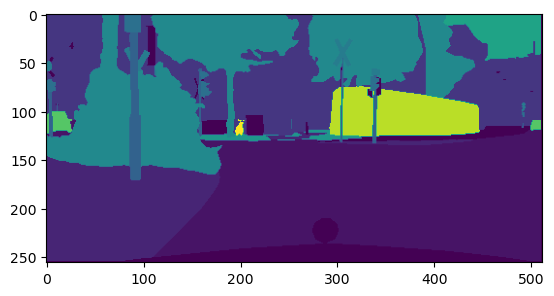

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(label_batch[0])

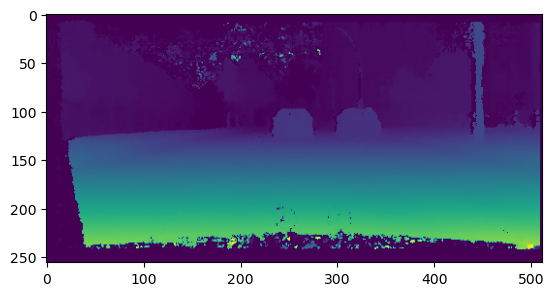

In [ ]:
plt.imshow(rgbd_batch[0][3])

In [ ]:
from SalsaCity import SalsaNext
model = SalsaNext(20,4)

In [ ]:
len(train_dataset)

2975

In [ ]:
from glob import glob
tfiles = glob('/arf/home/myadiyaman/projeler/hydracity/data/cityscapes/gtFine/train/*/*gtFine_labelIds.png')
vfiles = glob('/arf/home/myadiyaman/projeler/hydracity/data/cityscapes/gtFine/val/*/*gtFine_labelIds.png')
efiles = glob('/arf/home/myadiyaman/projeler/hydracity/data/cityscapes/gtFine/test/*/*gtFine_labelIds.png')

In [ ]:
len(tfiles), len(vfiles), len(efiles)

(2975, 500, 1525)

In [11]:
import os
import sys
import yaml
from SalsaNext import SalsaNext
sys.path.append('/arf/home/myadiyaman/projeler/hydracity/utils')

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from fastfill import FastFill
from scale3d import RandomRescaleRangeImage
from dskittiwaymo import SegmentationDataset

from metric_miou import calculate_classwise_intersection_union,calculate_final_miou_from_batches, calculate_miou
from printiou import print_miou_kitti as print_miou_results
from lovasz import Lovasz_softmax



num_classes = 20
batch_number = 24
max_epochs = 150             
learning_rate = 0.01     
warmup_epochs = 1            
momentum = 0.9              
lr_decay = 0.99                
weight_decay = 0.0001        
batch_size = 8                
epsilon_w = 0.001 

frequencies = [0.03150183342534689,
                0.042607828674502385,
                0.00016609538710764618,
                0.00039838616015114444,
                0.0021649398241338114,
                0.0018070552978863615,
                0.0003375832743104974,
                0.00012711105887399155,
                3.746106399997359e-05,
                0.19879647126983288,
                0.014717169549888214,
                0.14392298360372,
                0.0039048553037472045,
                0.1326861944777486,
                0.0723592229456223,
                0.26681502148037506,
                0.006035012012626033,
                0.07814222006271769,
                0.002855498193863172,
                0.0006155958086189918]


model = SalsaNext(20,5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.device_count()>1:
    model = torch.nn.DataParallel(model)
    model.to(device)
else:
    model.to(device)

print(device, ' is used')

ff = FastFill(tofill=0, indices=[0,1,2,3,4])



inverse_frequencies = [1.0 / (f + epsilon_w) for f in frequencies]
inverse_frequencies[0] = min(inverse_frequencies) / 10
criterion_nll = nn.NLLLoss(weight=torch.tensor(inverse_frequencies).to(device))
criterion_lovasz = Lovasz_softmax(ignore=0, from_logits=False)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

def warmup_lr_scheduler(optimizer, warmup_epochs, initial_lr):
    def lr_lambda(epoch):
        return epoch / warmup_epochs if epoch < warmup_epochs else 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

warmup_scheduler = warmup_lr_scheduler(optimizer, warmup_epochs, learning_rate)

best_mean_iou = 0.0
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        scheduler.step()

    for i, (images, masks) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        images, masks = images.to(torch.float32).to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion_nll(torch.log(outputs), masks) + criterion_lovasz(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {running_loss / len(train_dataloader):.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Validation phase
    model.eval()
    miou_total = 0.0
    batch_results = []

    with torch.no_grad():
        for i, (images, masks) in tqdm(enumerate(validation_dataloader)):
            images, masks = images.to(torch.float32).to(device), masks.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            miou = calculate_miou(preds, masks, num_classes, ignore_index=0)
            cwiou = calculate_classwise_intersection_union(preds, masks)
            batch_results.append(cwiou)

            miou_total += miou

    # Calculate and display mIoU metrics
    classwise_iou, mean_iou, total_iou = calculate_final_miou_from_batches(batch_results)
    print_miou_results(classwise_iou, mean_iou, total_iou)
    avg_miou = miou_total / len(validation_dataloader)
    print(f"Epoch [{epoch+1}/{max_epochs}], Validation mIoU: {avg_miou:.4f}")
    print('################################################')

    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou
        torch.save(model.state_dict(), f'kitti_best_model_state_dict.pth')
        print(f"New best mIoU: {best_mean_iou:.4f}. Model saved.")


torch.save(model.cpu().state_dict(), 'kitti_last_model_state_dict.pth')

ModuleNotFoundError: No module named 'albumentations'

In [13]:
from SalsaNext import SalsaNext
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys
sys.path.append('/arf/home/myadiyaman/projeler/hydracity/utils')


from metric_miou import (
    calculate_classwise_intersection_union,
    calculate_final_miou_from_batches,
    calculate_miou
)
from printiou import print_miou_kitti as print_miou_results
from lovasz import Lovasz_softmax

# Hyperparameters and configuration
num_classes = 20
max_epochs = 150             
learning_rate = 0.01     
warmup_epochs = 1            
momentum = 0.9              
lr_decay = 0.99                
weight_decay = 0.0001        
epsilon_w = 0.001 

frequencies = [
    0.03150183342534689,
    0.042607828674502385,
    0.00016609538710764618,
    0.00039838616015114444,
    0.0021649398241338114,
    0.0018070552978863615,
    0.0003375832743104974,
    0.00012711105887399155,
    3.746106399997359e-05,
    0.19879647126983288,
    0.014717169549888214,
    0.14392298360372,
    0.0039048553037472045,
    0.1326861944777486,
    0.0723592229456223,
    0.26681502148037506,
    0.006035012012626033,
    0.07814222006271769,
    0.002855498193863172,
    0.0006155958086189918
]

# Model setup
model = SalsaNext(num_classes, 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
print(device, 'is used')

# Loss functions
inverse_frequencies = [1.0 / (f + epsilon_w) for f in frequencies]
inverse_frequencies[0] = min(inverse_frequencies) / 10
criterion_nll = nn.NLLLoss(weight=torch.tensor(inverse_frequencies).to(device))
criterion_lovasz = Lovasz_softmax(ignore=0, from_logits=False)

# Optimizer and schedulers
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

def warmup_lr_scheduler(optimizer, warmup_epochs, initial_lr):
    def lr_lambda(epoch):
        return epoch / warmup_epochs if epoch < warmup_epochs else 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

warmup_scheduler = warmup_lr_scheduler(optimizer, warmup_epochs, learning_rate)

# Training and validation loops
best_mean_iou = 0.0
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        scheduler.step()

    for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        images = batch["yuvd"]  # Shape: (B, 4, H, W) It is YUVD actually
        masks = batch["label"]  # Shape: (B, H, W)
        images, masks = images.to(torch.float32).to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion_nll(torch.log(outputs), masks) + criterion_lovasz(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {running_loss / len(train_dataloader):.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Validation phase
    model.eval()
    miou_total = 0.0
    batch_results = []

    with torch.no_grad():
        for i, (images, masks) in tqdm(enumerate(validation_dataloader)):
            images, masks = images.to(torch.float32).to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            miou = calculate_miou(preds, masks, num_classes, ignore_index=0)
            cwiou = calculate_classwise_intersection_union(preds, masks)
            batch_results.append(cwiou)
            miou_total += miou

    classwise_iou, mean_iou, total_iou = calculate_final_miou_from_batches(batch_results)
    print_miou_results(classwise_iou, mean_iou, total_iou)
    avg_miou = miou_total / len(validation_dataloader)
    print(f"Epoch [{epoch+1}/{max_epochs}], Validation mIoU: {avg_miou:.4f}")
    print('################################################')

    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou
        torch.save(model.state_dict(), 'kitti_best_model_state_dict.pth')
        print(f"New best mIoU: {best_mean_iou:.4f}. Model saved.")

torch.save(model.cpu().state_dict(), 'kitti_last_model_state_dict.pth')


cpu is used


/arf/sw/apps/truba-ai/gpu/miniforge3-2024/envs/gpu-2024.0/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|          | 2/372 [01:46<5:08:52, 50.09s/it]